In [1]:
%matplotlib inline


# Fitting an image and points

In this example, we will fit a cross onto the same cross, but rotated. We will take advantage of this knowledge and use a rotation deformation module. We will also add some noise on the initial center guess to show how to fit the geometrical descriptors. In addition to images, we add points at the extremity of each branch that will also get matched in order to illustrate multi deformables matching. This also helps the fitting process by adding more information to the model.




Import relevant modules.




In [2]:
import sys
sys.path.append("../")

import math

import torch
import matplotlib.pyplot as plt
import scipy.ndimage

import imodal

imodal.Utilities.set_compute_backend('torch')

Load image data and generate dots.




In [3]:
source_image = imodal.Utilities.load_greyscale_image("../data/images/cross_+_30.png", origin='lower')
target_image = imodal.Utilities.load_greyscale_image("../data/images/cross_+.png", origin='lower')

# Smoothing
sig_smooth = 0.
source_image = torch.tensor(scipy.ndimage.gaussian_filter(source_image, sig_smooth))
target_image = torch.tensor(scipy.ndimage.gaussian_filter(target_image, sig_smooth))

extent_length = 31.
extent = imodal.Utilities.AABB(0., extent_length, 0., extent_length)

dots = torch.tensor([[0., 0.5],
                     [0.5, 0.],
                     [0., -0.5],
                     [-0.5, 0.]])

source_dots = 0.6*extent_length*imodal.Utilities.linear_transform(dots, imodal.Utilities.rot2d(math.pi/3)) + extent_length*torch.tensor([0.5, 0.5])

target_dots = 0.6*extent_length*imodal.Utilities.linear_transform(dots, imodal.Utilities.rot2d(math.pi/1)) + extent_length*torch.tensor([0.5, 0.5])

center = extent_length*torch.tensor([[0.3, 0.1]])

Plot everything.




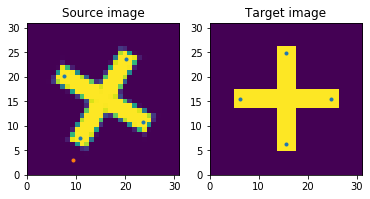

In [4]:
plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(source_image, origin='lower', extent=extent.totuple())
plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], '.')
plt.plot(center.numpy()[:, 0], center.numpy()[:, 1], '.')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(target_image, origin='lower', extent=extent.totuple())
plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], '.')

plt.show()

We know that the target cross is the result of some rotation at its origin,
so we use a local rotation deformation module, with an imprecise center
position to simulate data aquisition noise.




In [5]:
rotation = imodal.DeformationModules.LocalRotation(2, 2.*extent_length, gd=center)

Create the model by setting `True` for `fit_gd` so that it also optimize the
rotation center.




In [9]:
source_deformable = imodal.Models.DeformableImage(source_image, output='bitmap', extent='match', backward=False)
target_deformable = imodal.Models.DeformableImage(target_image, output='bitmap', extent='match', backward=False)

source_dots_deformable = imodal.Models.DeformablePoints(source_dots)
target_dots_deformable = imodal.Models.DeformablePoints(target_dots)

attachment = imodal.Attachment.L2NormAttachment(transform=None)

model = imodal.Models.RegistrationModel([source_deformable, source_dots_deformable], [rotation], [attachment, imodal.Attachment.EuclideanPointwiseDistanceAttachment()], fit_gd=[True], lam=1000.)

Fit the model.




In [10]:
shoot_solver = 'rk4'
shoot_it = 10
max_it = 100

costs = {}
fitter = imodal.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit([target_deformable, target_dots_deformable], max_it, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS, using solver rk4 with 10 iterations.
Initial cost={'deformation': 9.157991735504899e-30, 'attach': 262755.8125}
1e-10
Evaluated model with costs=262755.8125
Evaluated model with costs=261066.3581254743
Evaluated model with costs=260254.06347546354
Evaluated model with costs=250906.5535352826
Evaluated model with costs=224634.6916885376
Evaluated model with costs=245559.5577392578
Evaluated model with costs=196331.46520996094
Evaluated model with costs=197909.15858459473
Evaluated model with costs=195637.1006011963
Evaluated model with costs=195481.48300170898
Evaluated model with costs=194995.31466674805
Evaluated model with costs=192565.94577026367
Evaluated model with costs=182698.12182617188
Evaluated model with costs=174426.18408203125
Evaluated model with costs=223519.50329589844
Evaluated model with costs=163150.3877105713
Evaluated model with costs=289461.5544433594
Evaluated model with costs=260938.7130126953
Evaluated model with c

Plot total cost evolution.




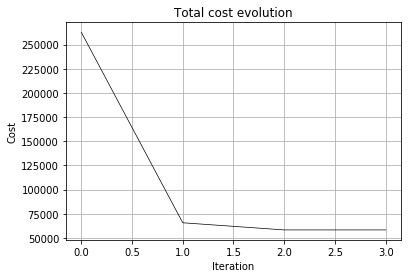

In [11]:
total_costs = [sum(cost) for cost in list(map(list, zip(*costs.values())))]

plt.title("Total cost evolution")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.plot(range(len(total_costs)), total_costs, color='black', lw=0.7)
plt.show()

Compute the final deformed source and plot it.




Fitted rotatation center: [[15.523761749267578, 15.479267120361328]]


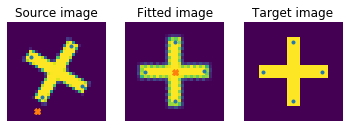

In [12]:
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it)

    deformed_image = deformed[0][0].view_as(source_image)
    deformed_dots = deformed[1][0]

fitted_center = model.init_manifold[2].gd.detach()

print("Fitted rotatation center: {center}".format(center=fitted_center.detach().tolist()))

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], '.')
plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(deformed_dots.numpy()[:, 0], deformed_dots.numpy()[:, 1], '.')
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target image")
plt.imshow(target_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], '.')
plt.axis('off')

plt.show()